# ANN Homework 1
* due 2021/11/01 14:00
* Author: Hung Chun Hsu (許鴻君)
* StudentID: R10946017
* Department: Data Science Program

---

##### 1. 請說明類神經網絡的特性與優點。...


---
##### 2. Give one example for each of the following topics:
(a) A book on neural networks or neuroinformatics:
> 	Deep Learning, Ian Goodfellow, Yoshua Bengio, Aaron CourvilleISBN: 0262035618, 9780262035613

---
##### 8. 延伸例題4.7改變模擬函數，如下所示：
$f(x,y) = \text{sin }x+2y^2$, where  $\text{x, y}\in(1,10)$

    (a) 產生三組資料群...

In [1]:
import math
import numpy as np

# declare function f(x,y)
def f(x,y):
    return math.sin(x)+2*y**2

# create training data matrix included 300 vectors of dimension 2.
train_data = np.random.uniform(low=1, high=10, size=(2,300))

# create training data matrix included 300 vectors of dimension 2.
validation_data = np.random.uniform(low=1, high=10, size=(2,100))

# create training data matrix included 300 vectors of dimension 2.
test_data = np.random.uniform(low=1, high=10, size=(2,100))

print(train_data.shape)
for i in range(5):
    print(train_data[:,i])
print(train_data[:,0].shape)

train_label = []; validation_value = []; test_value = []
for i in range(len(train_data[0,:])):
    train_label.append(f(train_data[0,i], train_data[1,i]))

for i in range(5):
    print(train_label[i])

# print(np.array(train_label).shape)
train_dataset = np.vstack((train_data, train_label))
#print(train_dataset)

(2, 300)
[2.26771837 5.07103492]
[7.925666   8.35588344]
[5.17121592 6.90536353]
[2.63185233 9.71758834]
[9.93140044 3.12781859]
(2,)
52.19761180506858
140.6390079810332
94.47151841044864
189.35099693196517
19.081271454760344


###### plot the dots of training/validation/testing data scattered in space separately.

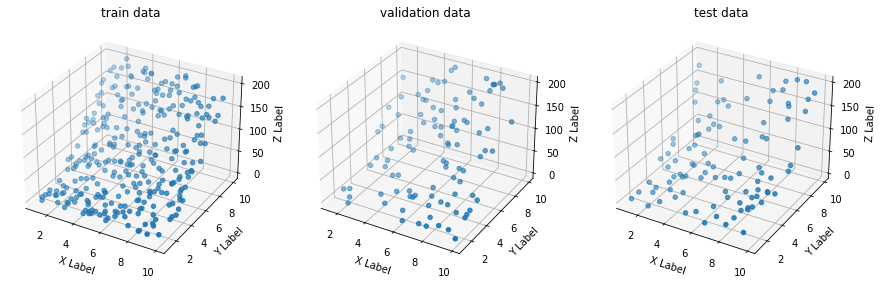

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(131, projection='3d')



xs = train_data[0,:]; ys = train_data[1,:]; zs = train_label
ax1.scatter(xs, ys, zs)
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('train data')

ax2 = fig.add_subplot(132, projection='3d')
for i in range(len(validation_data[0,:])):
    validation_value.append(f(validation_data[0,i], validation_data[1,i]))
xs = validation_data[0,:]; ys = validation_data[1,:]; zs = validation_value
ax2.scatter(xs, ys, zs)
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('validation data')

ax3 = fig.add_subplot(133, projection='3d')
for i in range(len(test_data[0,:])):
    test_value.append(f(test_data[0,i], test_data[1,i]))
xs = test_data[0,:]; ys = test_data[1,:]; zs = test_value
ax3.scatter(xs, ys, zs)
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')
ax3.set_title('test data')

plt.show()

---
(b) 以類神經網路來訓練、測試及推估函數

In [3]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
# Training Device
device = torch.device("cuda")

# Hyperparameters
BATCH_SIZE = 50
EPOCH = 10000

# Set up dataloader
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

# data length
train_data_size = len(train_data[0])
test_data_size = len(test_data[0])

# Define Neural Network
class NETWORK(nn.Module):
    def __init__(self):
        super(NETWORK, self).__init__()
        self.model1 = Sequential(
            nn.Linear(2,4),
            nn.ReLU(),
            nn.Linear(4,4),
            nn.ReLU(),
            nn.Linear(4,1)
        )
    def forward(self, x):
        x = self.model1(x)
        return x

network = NETWORK()
if torch.cuda.is_available():
    network = network.to(device)

# Set loss function
loss_fn = nn.MSELoss()
if torch.cuda.is_available():
    loss_fn = loss_fn.to(device)
learning_rate = 0.2

#optimizer = torch.optim.Adagrad(network.parameters(), lr=learning_rate)
optimizer = torch.optim.Adadelta(network.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)

# set parameters
total_train_step = 0
total_test_step = 0

# Input Normalization
#mean_of_train_data = np.sum(train_data)/len(train_data[1])
#print(f'Mean of training data:{mean_of_train_data}')
input_normalization = 0
if (input_normalization==1):
    std = np.linalg.norm(train_data)
    train_data = train_data/std
# print(train_data)

def get_batch(train_dataset):
    # 隨機從 train data 中抽出 50組 樣本 進行訓練。
    train_dataset = np.transpose(train_dataset)
    #print(f'dimension of train dataset: {np.array(train_dataset.shape)}')
    number_of_rows = train_dataset.shape[0]
    random_inidices = np.random.choice(number_of_rows, size=BATCH_SIZE, replace=False)
    batch_train_dataset = train_dataset[random_inidices, :]

    #print(batch_train_dataset)
    batch_train_data, batch_train_label = np.hsplit(batch_train_dataset, [2])
    batch_train_data = np.transpose(batch_train_data)
    batch_train_label = np.squeeze(batch_train_label)
    batch_train_data = Variable(torch.Tensor(batch_train_data))
    batch_train_label = Variable(torch.Tensor(batch_train_label))
    #print(batch_train_label)

    return batch_train_data, batch_train_label


for epoch in range(EPOCH):
    if epoch % 200 == 0:
        print(f"===EPOCH:{epoch}===")

    # set to training mode
    network.train()
    batch_train_data, batch_train_label = get_batch(train_dataset)

    for i in range(len(batch_train_data[1])):
            #print(train_data[:][data])
        inputs = batch_train_data[:,i]
            #inputs = torch.Tensor(inputs)
        outputs = network(inputs)

        if torch.cuda.is_available():
            inputs = inputs.to(device)
            batch_train_label[i] = batch_train_label[i].to(device)

        loss = loss_fn(outputs, batch_train_label[i])

        # something about optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_step = total_train_step + 1

    # set to test mode
    network.eval()
    total_test_loss = 0
    absone_total_accuracy = 0
    fiveper_total_accuracy = 0
    tenper_total_accuracy = 0

    with torch.no_grad():
        for i in range(len(test_data[0])):
            inputs = test_data[:,i]
            inputs = torch.Tensor(inputs)

            if torch.cuda.is_available():
                inputs = inputs.to(device)
                test_value[i] = test_value[i].to(device)

            outputs = network(inputs)
            loss = outputs - test_value[i]
            total_test_loss = total_test_loss + loss

            if abs(outputs - test_value[i]) < 1: absone_accuracy = 1
            else: absone_accuracy = 0
            absone_total_accuracy = absone_total_accuracy + absone_accuracy
            if abs(outputs - test_value[i]) < 0.05*test_value[i]: fiveper_accuracy = 1
            else: fiveper_accuracy = 0
            fiveper_total_accuracy = fiveper_total_accuracy + fiveper_accuracy
            if abs(outputs - test_value[i]) < 0.1*test_value[i]: tenper_accuracy = 1
            else: tenper_accuracy = 0
            tenper_total_accuracy = tenper_total_accuracy + tenper_accuracy
    if epoch % 200 == 0:
        print("Loss of test dataset: {}".format(total_test_loss))
        print(f"Overall accuracy of test dataset:")
        print(f"   +-1: {absone_total_accuracy/test_data_size} = {absone_total_accuracy}/{test_data_size}")
        print(f"   5% : {fiveper_total_accuracy/test_data_size} = {fiveper_total_accuracy}/{test_data_size}")
        print(f"   10%: {tenper_total_accuracy/test_data_size} = {tenper_total_accuracy}/{test_data_size}")
    total_test_step = total_test_step + 1

    #torch.save(tudui, "tudui_{}.pth".format(i))
    #print("模型已保存")


===EPOCH:0===
Loss of test dataset: tensor([-8595.1445])
Overall accuracy of test dataset:
   +-1: 0.0 = 0/100
   5% : 0.01 = 1/100
   10%: 0.03 = 3/100


c:\users\woody\desktop\(mon_567)_artificial_neural_network\homework\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


===EPOCH:200===
Loss of test dataset: tensor([-228.5648])
Overall accuracy of test dataset:
   +-1: 0.04 = 4/100
   5% : 0.07 = 7/100
   10%: 0.13 = 13/100
===EPOCH:400===
Loss of test dataset: tensor([-34.6551])
Overall accuracy of test dataset:
   +-1: 0.11 = 11/100
   5% : 0.25 = 25/100
   10%: 0.37 = 37/100
===EPOCH:600===
Loss of test dataset: tensor([-31.6807])
Overall accuracy of test dataset:
   +-1: 0.08 = 8/100
   5% : 0.24 = 24/100
   10%: 0.39 = 39/100


KeyboardInterrupt: 

In [ ]:
print(torch.cuda.is_available())
A = np.array([[1,2,3],[4,5,6]])
print(A[:,0])
number_of_rows = A.shape[0]
print(number_of_rows)
random_indicies = np.random.choice(number_of_rows, size=1, replace=False)
print(random_indicies)
random_rows = A[random_indicies,:]
print(random_rows)
print(random_rows.shape)

In [ ]:
A = np.array([[1,2,3],[4,5,6]])
print(A.shape)
B = np.array([7,8,9])
print(B.shape)
C = np.vstack((A, B))
print(C)
X, Y = np.hsplit(C, [2])
print(X, Y)
print(X.shape)
print(Y.shape)
Y = np.squeeze(Y)
print(Y.shape)